In [11]:
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import os

In [108]:
def cv2_imshow(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

<h1>Get data</h1>

In [13]:
def split_image(image, rows, cols):
    # Get the dimensions of the image
    height, width = image.shape[:2]
    
    # Calculate the height and width of each sub-image
    sub_height = height // rows
    sub_width = width // cols
    
    # Create a list to store the sub-images
    sub_images = []
    
    for row in range(rows):
        for col in range(cols):
            # Calculate the coordinates of each sub-image
            start_y = row * sub_height
            start_x = col * sub_width
            end_y = (row + 1) * sub_height
            end_x = (col + 1) * sub_width
            
            # Crop the sub-image
            sub_image = image[start_y:end_y, start_x:end_x]
            sub_images.append(sub_image)
    
    return sub_images

def get_center_region(image):
    # Detect the UAV in the frame
    # Get image dimensions
    height, width = image.shape[:2]

    # Calculate the center and radius for the circular crop
    center_x, center_y = width // 2, height // 2
    radius = min(center_x, center_y, width//4)  # Radius is limited by the smallest dimension

    # Crop the rectangular bounding box around the circle
    x1, y1 = center_x - radius, center_y - radius
    x2, y2 = center_x + radius, center_y + radius

    return image[y1:y2, x1:x2]

def extract_images(video_path, output_dir, num_frames):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the interval to extract evenly spaced frames
    interval = total_frames / num_frames
    
    file_name = os.path.join(output_dir, os.path.splitext(os.path.basename(video_path))[0])
    num_images = 0
    for i in tqdm(range(num_frames), desc=f"Progressive {file_name}", leave=True):
        # Set the position of the next frame
        frame_id = round(i * interval)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        
        # Read the frame
        ret, frame = cap.read()
        if not ret:
            break  # Break if unable to read the frame
        
        center_region = get_center_region(frame)
        cv2.imwrite(f"{file_name}_{i}.jpg", center_region)
        num_images += 1
    
    cap.release()
    return num_images

In [14]:
# Capture video from the webcam or a video file
video_path = "Images/Sources"
output_path = "Images/Data"
video_names = os.listdir(video_path)
num_imgs = 0
for i, video_name in enumerate(video_names):
    num = extract_images(os.path.join(video_path, video_name), output_path, 400)  # Change to the video file path if needed
    num_imgs += num
print(f"num images: {num_imgs}")

Progressive Images/Data\WIN_20241101_08_28_33_Pro: 100%|██████████| 400/400 [00:30<00:00, 13.05it/s]
Progressive Images/Data\WIN_20241101_14_23_19_Pro: 100%|██████████| 400/400 [00:36<00:00, 11.04it/s]
Progressive Images/Data\WIN_20241101_14_26_40_Pro: 100%|██████████| 400/400 [00:39<00:00, 10.23it/s]
Progressive Images/Data\WIN_20241106_14_41_25_Pro: 100%|██████████| 400/400 [00:34<00:00, 11.47it/s]
Progressive Images/Data\WIN_20241106_14_46_25_Pro: 100%|██████████| 400/400 [00:34<00:00, 11.59it/s]
Progressive Images/Data\WIN_20241106_14_47_15_Pro: 100%|██████████| 400/400 [00:33<00:00, 11.77it/s]
Progressive Images/Data\WIN_20241106_14_56_09_Pro: 100%|██████████| 400/400 [00:33<00:00, 11.83it/s]
Progressive Images/Data\WIN_20241106_14_57_42_Pro: 100%|██████████| 400/400 [00:25<00:00, 15.71it/s]
Progressive Images/Data\WIN_20241106_14_58_08_Pro: 100%|██████████| 400/400 [00:29<00:00, 13.77it/s]
Progressive Images/Data\WIN_20241106_15_01_04_Pro: 100%|██████████| 400/400 [00:30<00:00, 1

num images: 6800


<h1>Auto annotation</h1>

In [12]:
from ultralytics import YOLO

In [2]:
model = YOLO("yolo11m.pt")  # load a pretrained model (recommended for training)

In [ ]:
# Train the model
results = model.train(data="datasetConfigure.yaml", epochs=100, imgsz=640, device=0)

In [4]:
# Load a model
model = YOLO("runs//detect//train//weights//best.pt")  # pretrained YOLO11n model

In [117]:
# Run batched inference on a list of images
img = "Images//Data//WIN_20241101_14_23_19_Pro_395.jpg"
results = model(img)  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename=f"Images//test//{os.path.basename(img)}")  # save to disk


image 1/1 e:\TAILIEU\MyProject\AI_Project\UAV_Detection\Images\Data\WIN_20241101_14_23_19_Pro_395.jpg: 640x640 (no detections), 55.0ms
Speed: 5.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


<h1>Train</h1>

<h1>Export</h1>

In [ ]:
# Load the YOLO11 model
model = YOLO("runs//detect//train//weights//best.pt")

# Export the model to ONNX format
model.export(format="onnx")  # creates 'yolo11m.onnx'

In [14]:
# Load the exported ONNX model
onnx_model = YOLO("runs//detect//train//weights//best.pt")

In [16]:
# Run inference
img = "Images//Data//WIN_20241106_14_41_25_Pro_99.jpg"
inp = cv2.imread(img)
results = onnx_model(inp, conf=0.4, device=0)
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    # result.show()  # display to screen
    # result.save(filename=f"Images//test//{os.path.basename(img)}")  # save to disk


0: 640x640 1 UAV, 257.0ms
Speed: 10.0ms preprocess, 257.0ms inference, 57.0ms postprocess per image at shape (1, 3, 640, 640)


In [17]:
boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.6201], device='cuda:0')
data: tensor([[ 42.6787, 568.7203, 172.9403, 613.1460,   0.6201,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (960, 960)
shape: torch.Size([1, 6])
xywh: tensor([[107.8095, 590.9332, 130.2615,  44.4257]], device='cuda:0')
xywhn: tensor([[0.1123, 0.6156, 0.1357, 0.0463]], device='cuda:0')
xyxy: tensor([[ 42.6787, 568.7203, 172.9403, 613.1460]], device='cuda:0')
xyxyn: tensor([[0.0445, 0.5924, 0.1801, 0.6387]], device='cuda:0')

In [23]:
for box in boxes.xyxy:
    print(box[0].item())

42.67873764038086


In [20]:
len(boxes.cls)

1

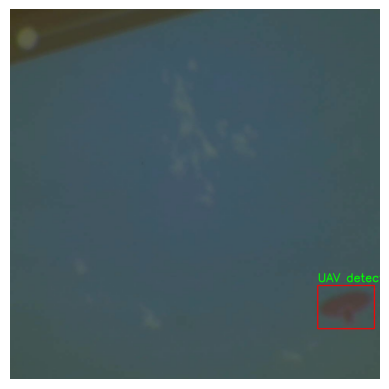

In [115]:
frame = result.orig_img
x = int(boxes.xyxy[0][0].item())
y = int(boxes.xyxy[0][1].item())
x1 = int(boxes.xyxy[0][2].item())
y1 = int(boxes.xyxy[0][3].item())
cv2.rectangle(frame, (x, y), (x1, y1), (0, 0, 255), 2)
cv2.putText(frame, "UAV detected", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2_imshow(frame)

<h1>Test</h1>

In [1]:
import tensorrt as trt
print(trt.__version__)

10.6.0
